<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 14 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 5 December 2022, with material from Carl Rasmussen, Chris Fonnesbeck, and John P. Cunningham</div>

# Gaussian Mixture Models

So far in class, we've built models for datasets with single-humped histograms. Waht happens if our histogram is not a camel?

<br />
<left>
<img src="ipynb.images/camel-one-hump.jpg" width=600 />
</left>

..but a dromadary:

<br />
<left>
<img src="ipynb.images/camel-two-humps.jpg" width=600 />
</left>

..or even worse, a scary dragon:

<br />
<left>
<img src="ipynb.images/multi-h.png" width=600 />
</left>

Well then, let's try to approximate the shape as a **superposition of gaussians**! We could also assume that each gaussian forms a group, and that our final data's histogram represents a combination of multiple **groupings**.

[Gaussian Mixture Models](https://scikit-learn.org/stable/modules/mixture.html) (GMM) are a neat methodolgy for modelling observations that stem from *multiple groupings*. 

A [mixture model](https://en.wikipedia.org/wiki/Mixture_model) is a probabilistic model for representing the presence of *subpopulations within an overall population, without requiring that an observed data set should identify the sub-population to which an individual observation belongs*. 

Mixture models are used to make statistical inferences about the properties of sub-populations given only observations on the pooled population, without sub-population identity information.

This is my go-to method for general model-building when the histogram of my dataset is not single-humped.

Let's draw normal distributions from 3 different populations and mix them in. Yup, that's professor *cheating again* by creating a dataset that will be easy to model😎

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


AttributeError: 'Rectangle' object has no property 'normed'

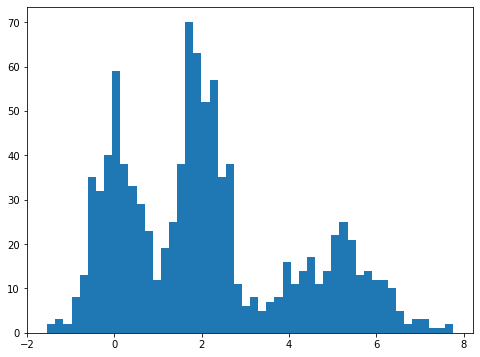

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

SEED = 25
np.random.seed(SEED) 

N = 1000
W = np.array([0.35, 0.4, 0.25])
MU = np.array([0., 2., 5.])
SIGMA = np.array([0.5, 0.5, 1.])

component = np.random.choice(MU.size, size=N, p=W)  #1st arg: arange(MU.size), p: probabilities associated with each 1sy arg entry 
x = np.random.normal(MU[component], SIGMA[component], size=N) #random samples from a normal distribution @ 1st arg

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(x, bins=50, normed=True, lw=0);

Since we sampled the data from normal distributions, our histogram will look similar:

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

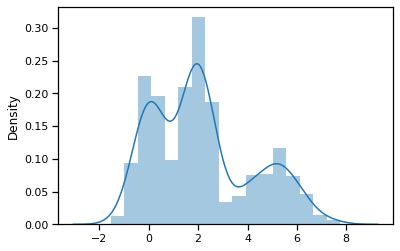

In [2]:
import seaborn as sns
sns.set_context('notebook')

sns.distplot(x)

So, we all agree this is a new histogram shape for us, yes? The back of a scary-looking dragon!

<br />
<left>
<img src="ipynb.images/stegosaurus.gif" width=400 />
</left>

We can only *hope* that our scary-looking dragon can be approximated by a superposition of gaussians. The **data likelihood**
function for that in pymc3 is called a `NormalMixture`. Let's specify and fit a marginalized Gaussian mixture model (GMM) to this data in pymc3. 

We introduce yet another new pdf here class, one called **Dirichlet**. The [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) is the multivariate generalization of the beta distribution (our "baseball" distribution, used to model the behavior of random variables limited to intervals of finite length). 

The Dirichlet distribution is used a lot in [Natural Language Processing](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) ([NLP](https://en.wikipedia.org/wiki/Natural_language_processing)).

It has as many parameters as the rank of the multivariate distribution you are trying to model.

The Dirichlet pdf does not sample from the space of *all* real numbers, like the normal pdf does. Instead it samples over a probability [simplex](https://en.wikipedia.org/wiki/Simplex) (probabilities over $n$ distinct categories, representing the dimensions of our multivariate distribution). A 4-dimentional Dirichlet distribution has 4 parameters. So, it's tailor-made for mixture models.

Here, we have a 3-variate distribution (3 components in our mixture), information we dial into our model with `shape=W.size`.

A `NormalMixture` has 3 parameters: `w`, `mu`, and `tau`:

In [3]:
with pm.Model() as model_mm:
    w = pm.Dirichlet('w', np.ones_like(W))  #array of ones with the same shape and type as W

    mu = pm.Normal('mu', 0., 10., shape=W.size)
    tau = pm.Gamma('tau', 1., 1., shape=W.size)

    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=x)

In [4]:
with model_mm:
    trace_mm = pm.sample(5000, n_init=10000, tune=1000, random_seed=SEED, cores=1)[1000:]

C:\Users\HP\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, mu, w]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


The posterior distribution on the weights and the component means captures the true values quite well:

d:\Anaconda3.5.1\lib\site-packages\pymc3\plots\__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
d:\Anaconda3.5.1\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


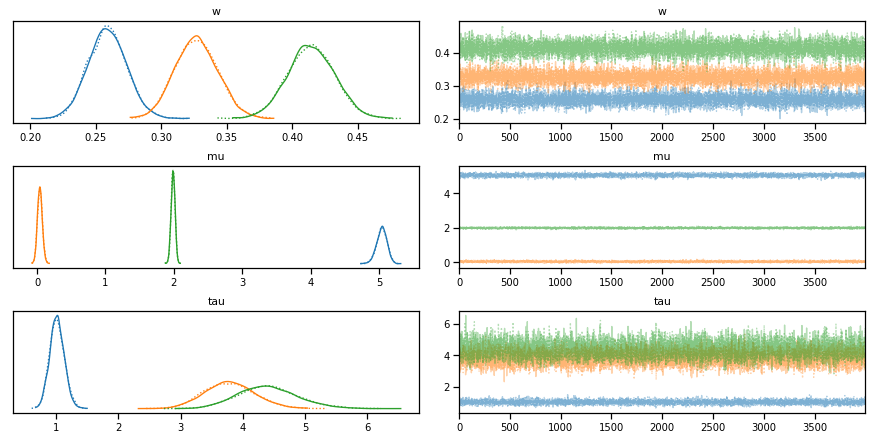

In [5]:
pm.traceplot(trace_mm, varnames=['w', 'mu', 'tau']);

d:\Anaconda3.5.1\lib\site-packages\pymc3\plots\__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
d:\Anaconda3.5.1\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


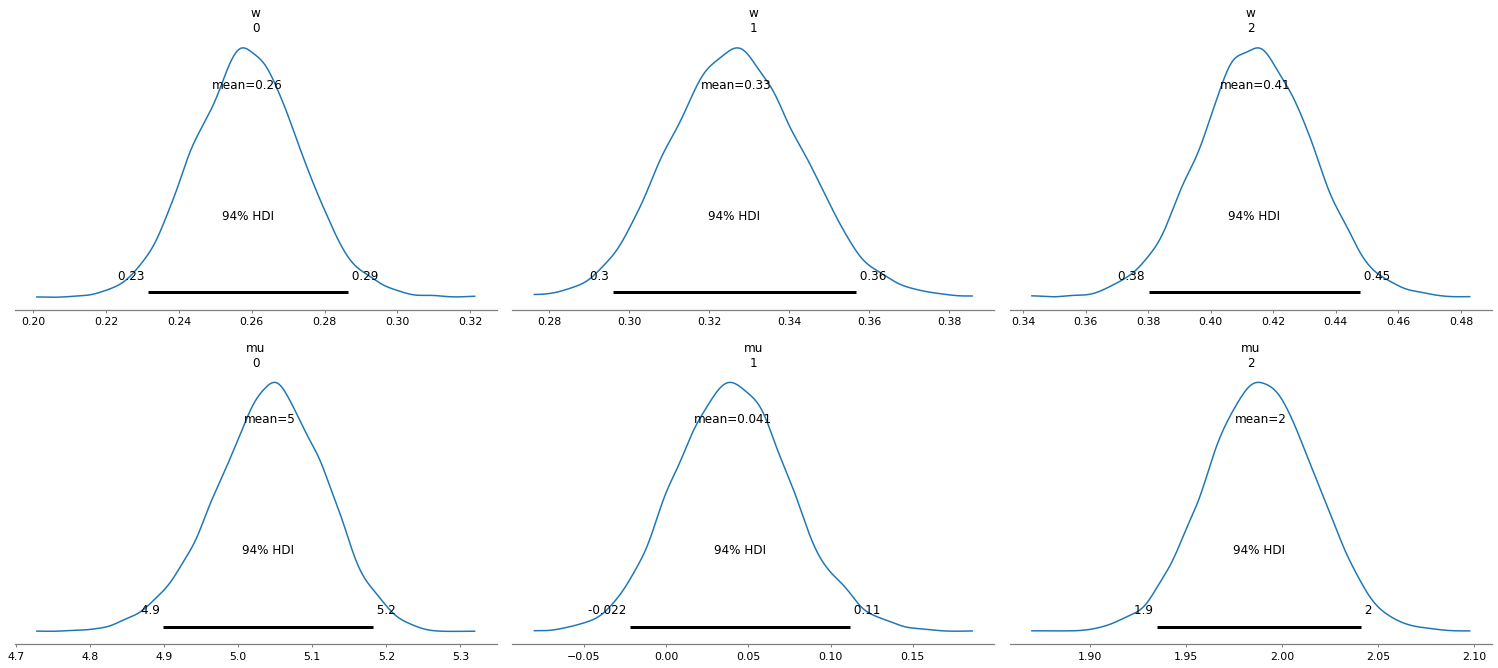

In [6]:
pm.plot_posterior(trace_mm, varnames=['w', 'mu']);

Let's sample from the model’s posterior predictive distribution:

In [7]:
with model_mm:
    ppc_trace = pm.sample_ppc(trace_mm, 500, random_seed=SEED)

d:\Anaconda3.5.1\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
d:\Anaconda3.5.1\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:19<00:00, 25.59it/s]


and let's plot the histogram of our predictions with the histogram of our data:

d:\Anaconda3.5.1\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
d:\Anaconda3.5.1\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


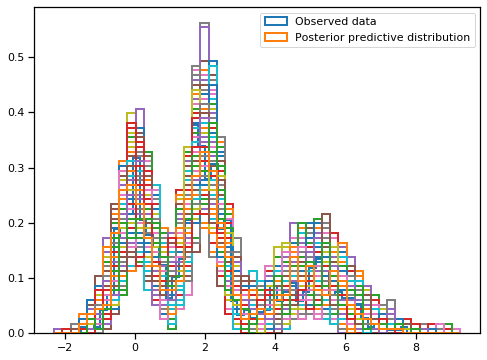

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=50, normed=True,
        histtype='step', lw=2,
        label='Observed data');

ax.hist(ppc_trace['x_obs'], bins=50, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

ax.legend(loc=1);

Not too shabby...

These individual Gaussian distributions are fit using an expectation-maximization method, much as in K means, except that rather than explicit cluster assignment, the **posterior probability** is used to compute the weighted mean and covariance.
This algorithm **provably** converges to the optimum, though the optimum is not necessarily *global*.

>**Example**: If a sports team is comprised of 11 players, each with his own abilities in passes or distance covered (with a superstar on some teams with way above average abilities, e.g. a Lionel Messi, or Kylian Mbappe), then team abilities could be considered as a multivariate distribution of 11 players, and modeled as a GMM. That way, you could go from individual player rankings to complete team rankings.

### What if we don't know the number of components?

We are cheating here a little bit, aren't we? We **specify** the number of gaussians in the mixture! It's a bit as if we doing KMeans where we specify the number of **clusters** in the model.

Assume we have another similar one-dimensional distribution that is a mixture of 3 gaussians where the 3 components are not that easy to distinguish:

AttributeError: 'Rectangle' object has no property 'normed'

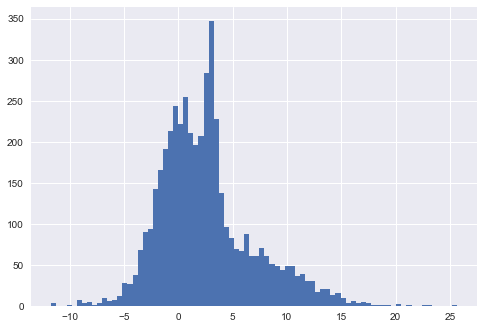

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn')

np.random.seed(2)
x = np.concatenate([np.random.normal(0, 2, 2000),
                    np.random.normal(5, 5, 2000),
                    np.random.normal(3, 0.5, 600)])
plt.hist(x, 80, normed=True)
plt.xlim(-10, 20);

`Scikit-learn`'s Gaussian Mixture Models (GMM) will allow us to approximate this density.

> **NOTE**: You may have to replace:
```(python)
from sklearn.mixture import GMM
```
with:
```(python)
from sklearn.mixture import GaussianMixture.
```

Suppose *we don't know the number of gaussian components in our dataset*. Let's try modeling with a mixture of ***four*** gaussians instead:

AttributeError: 'Rectangle' object has no property 'normed'

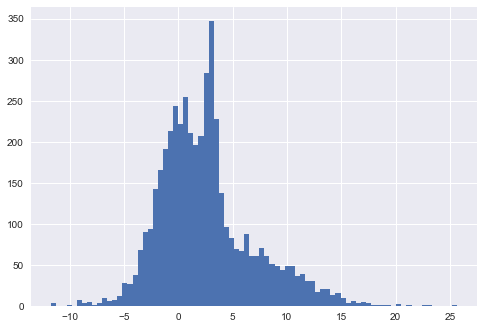

In [6]:
#from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
X = x[:, np.newaxis]

# # fit a Gaussian Mixture Model with 4 components
#clf = GMM(4, n_iter=500, random_state=3).fit(X)
clf = GaussianMixture(4, random_state=3).fit(X)

xpdf = np.linspace(-10, 20, 1000)
#density = np.exp(clf.score(xpdf[:, np.newaxis]))
density = np.exp(clf.score_samples(xpdf[:, np.newaxis]))

plt.hist(x, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

Note that this density is fit using a **mixture of Gaussians**, which we can examine by looking at the ``means_``, ``covars_``, and ``weights_`` attributes:

In [7]:
clf.means_

array([[-1.762037  ],
       [ 8.04894855],
       [ 2.87628921],
       [-0.26509542]])

In [12]:
#clf.covars_
clf.covariances_

array([[[ 7.39304484]],

       [[14.2611261 ]],

       [[ 1.25253655]],

       [[ 2.1852085 ]]])

In [13]:
clf.weights_

array([0.15154409, 0.2532411 , 0.28492403, 0.31029078])

Let's demarcate the 4 components:

d:\Anaconda3.5.1\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


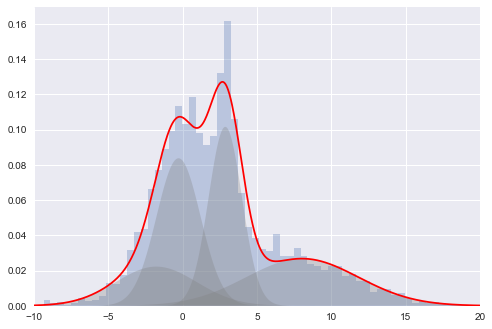

In [14]:
plt.hist(x, 80, normed=True, alpha=0.3)
plt.plot(xpdf, density, '-r')

for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covariances_[i, 0])).pdf(xpdf)
    plt.fill(xpdf, pdf, facecolor='gray',
             edgecolor='none', alpha=0.3)
plt.xlim(-10, 20);

How to gauge the correct number of components?

The [Akaike information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) (AIC) and the [Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (BIC) are estimators of **prediction error** and thereby relative quality of statistical models for a given set of data.

AIC deals with the trade-off between the **goodness of fit** of the model and the **simplicity** of the model. In other words, AIC deals with both the risk of **overfitting** and the risk of **underfitting**.
 
Models with *lower* AIC or BIC are generally preferred.

In [15]:
# compute the AIC and the BIC
AIC = clf.aic(X)
BIC = clf.bic(X)
AIC, BIC

(25754.42998281726, 25825.201910224507)

Now let's try with a mixture of ***three*** components:

d:\Anaconda3.5.1\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


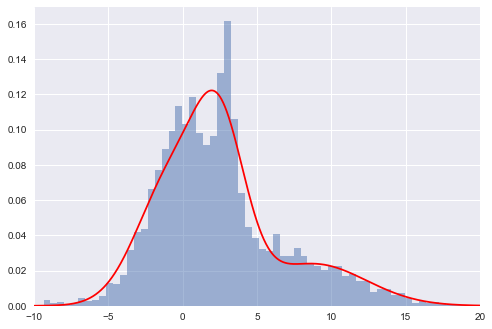

In [16]:
#from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
X = x[:, np.newaxis]

# # fit a Gaussian Mixture Model with 3 components
clf = GaussianMixture(3, random_state=3).fit(X)
xpdf = np.linspace(-10, 20, 1000)
density = np.exp(clf.score_samples(xpdf[:, np.newaxis]))

plt.hist(x, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

d:\Anaconda3.5.1\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


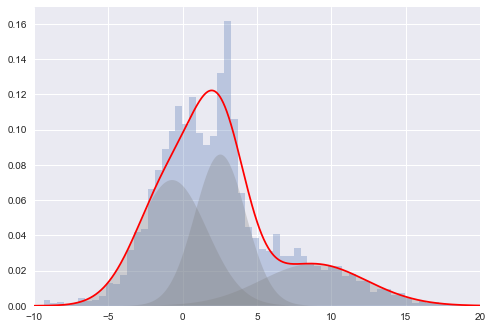

In [17]:
plt.hist(x, 80, normed=True, alpha=0.3)
plt.plot(xpdf, density, '-r')

for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covariances_[i, 0])).pdf(xpdf)
    plt.fill(xpdf, pdf, facecolor='gray',
             edgecolor='none', alpha=0.3)
plt.xlim(-10, 20);

In [18]:
# compute the AIC and the BIC
AIC = clf.aic(X)
BIC = clf.bic(X)
AIC, BIC

(25885.965756347665, 25937.436249007482)

Hmm, it appears that 3 components gives us a higher BIC and a higher AIC. Oopsie.. 

But the values are very close, and since it's only 3 verus 4, I will prefer 3 components! :-)

>**Note**: In Bayesian statistics as in ML, reducing the number of parameters in your model without significantly degrading the quality of the model is usually preferred.

One could could try a few different models and plot prediction errors:

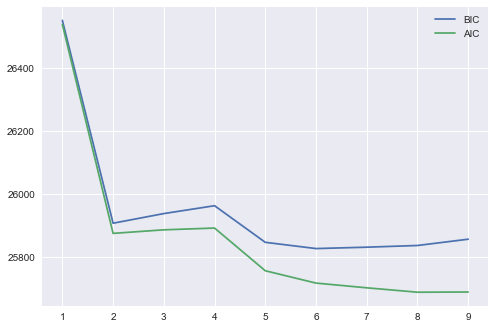

In [19]:
n_estimators = np.arange(1, 10)
clfs = [GaussianMixture(n).fit(X) for n in n_estimators]
bics = [clf.bic(X) for clf in clfs]
aics = [clf.aic(X) for clf in clfs]

plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')
plt.legend();

It appears that for BIC, 6 components are preferred, and 9 for AIC. These criteria estimate the 2 components is probably good enough, though. 

### GMMs For Outlier Detection

GMM is what is known as a **generative model**: it's a probabilistic model from which a dataset can be generated.

One thing that generative models can be useful for is **outlier detection**: We can simply evaluate the likelihood of each point under the generative model; the points with a suitably *low* likelihood (where **suitable** is up to your own bias/variance preference) can be labeled **outliers**.

Let's take a look at this by adding **outliers** to our dataset:

In [20]:
np.random.seed(0)

# Add 20 outliers
true_outliers = np.sort(np.random.randint(0, len(x), 20))
y = x.copy()
y[true_outliers] += 50 * np.random.randn(20)

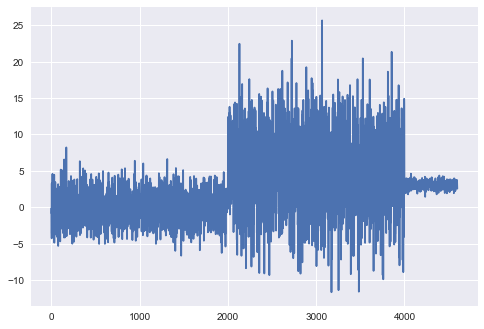

In [21]:
plt.plot(x)

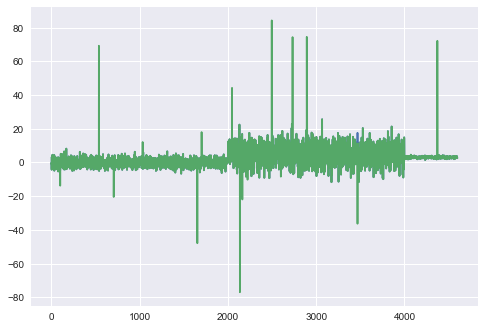

In [22]:
plt.plot(x)
plt.plot(y)

(array([  3.,   0.,   0.,   1.,   0.,   7.,   3.,   5.,   1.,   3.,  10.,
          6.,   7.,  12.,  28.,  26.,  38.,  68.,  90.,  93., 142., 166.,
        191., 213., 243., 222., 255., 211., 196., 207., 284., 347., 228.,
        137.,  96.,  83.,  69.,  67.,  87.,  61.,  61.,  70.,  61.,  51.,
         48.,  44.,  49.,  49.,  36.,  39.,  30.,  30.,  17.,  20.,  20.,
         13.,  15.,   9.,   4.,   6.,   3.,   5.,   4.,   1.,   1.,   1.,
          1.,   0.,   2.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   1.]),
 array([-1.16728485e+01, -1.12061027e+01, -1.07393570e+01, -1.02726112e+01,
        -9.80586549e+00, -9.33911974e+00, -8.87237398e+00, -8.40562823e+00,
        -7.93888248e+00, -7.47213673e+00, -7.00539098e+00, -6.53864523e+00,
        -6.07189948e+00, -5.60515373e+00, -5.13840798e+00, -4.67166223e+00,
        -4.20491648e+00, -3.73817073e+00, -3.27142498e+00, -2.80467923e+00,
        -2.33793348e+00, -1.87118773e+00, -1.40444198e+00, -9.37696227e-01

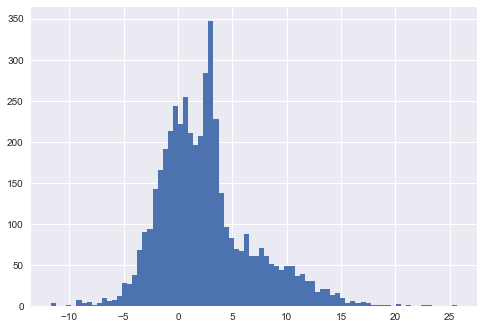

In [23]:
plt.hist(x, 80)

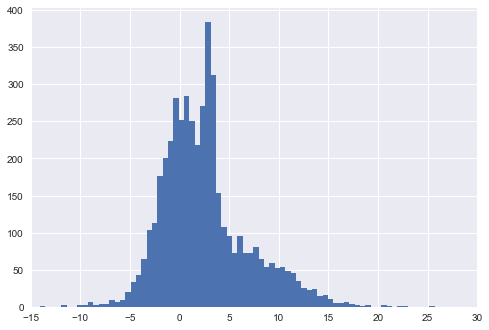

In [24]:
plt.hist(y, 300)
plt.xlim(-15, 30);

Now let's try to fit a Gaussian Mixture model with 4 components:

d:\Anaconda3.5.1\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


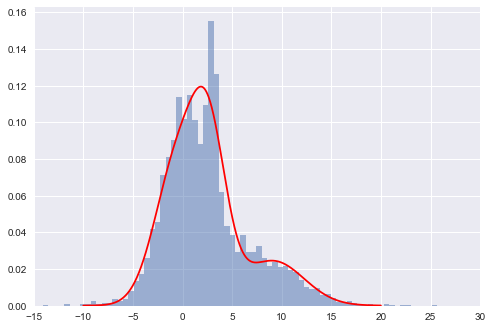

In [25]:
clf = GaussianMixture(4, random_state=0).fit(y[:, np.newaxis])
xpdf = np.linspace(-10, 20, 1000)
density_noise = np.exp(clf.score_samples(xpdf[:, np.newaxis]))

plt.hist(y, 300, normed=True, alpha=0.5)
plt.plot(xpdf, density_noise, '-r')
plt.xlim(-15, 30);

Let's evaluate the log-likelihood of each point under the model, and plot these as a function of ``y``:

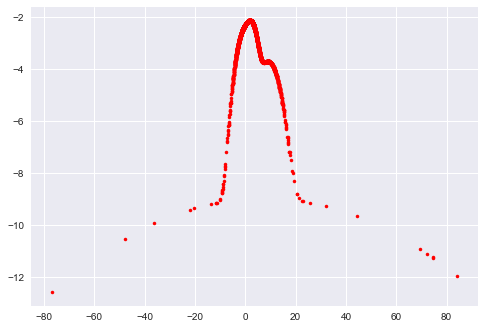

In [26]:
log_likelihood = clf.score_samples(y[:, np.newaxis])
plt.plot(y, log_likelihood, '.r');

In [27]:
detected_outliers = np.where(log_likelihood < -9)[0]

print("true outliers:")
print(true_outliers)
print("\ndetected outliers:")
print(detected_outliers)

true outliers:
[  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607
 2732 2893 2897 3264 3468 4373]

detected outliers:
[  99  537  705 1653 2046 2130 2135 2163 2222 2496 2724 2732 2893 2897
 3067 3173 3253 3468 3483 4373]


The algorithm **misses** a few of these points, which is to be expected (some of the "outliers" actually land in the middle of the distribution!)

Here are the outliers that were missed (**false negatives**):

In [28]:
set(true_outliers) - set(detected_outliers)

{1033, 1701, 1871, 2599, 2607, 3264}

And here are the non-outliers which were spuriously labeled outliers (**false positives**):

In [29]:
set(detected_outliers) - set(true_outliers)

{2130, 2724, 3067, 3173, 3253, 3483}

Although all of the above is done in one dimension, GMM does generalize to multiple dimensions!

### Other Density Estimators

The other main density estimator that you might find useful is *Kernel Density Estimation*, which is available via ``sklearn.neighbors.KernelDensity``. In some ways, this can be thought of as a generalization of GMM where there is a gaussian placed at the location of *every* training point!

d:\Anaconda3.5.1\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass bandwidth=0.15 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


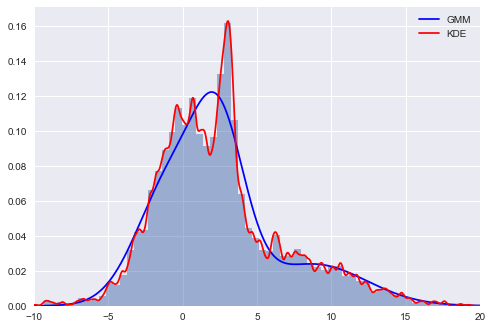

In [30]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(0.15).fit(x[:, None])
density_kde = np.exp(kde.score_samples(xpdf[:, None]))

plt.hist(x, 80, density=True, alpha=0.5)
plt.plot(xpdf, density, '-b', label='GMM')
plt.plot(xpdf, density_kde, '-r', label='KDE')
plt.xlim(-10, 20)
plt.legend();

GMMs are simpler models, whereas KDE fits closer to the data, potentially learning noise (not a good thing).

All of these density estimators can be viewed as **generative models** of the data: that is, that is, the model tells us how more data can be created which fits the model.

# Conclusion

I actually won a prize using GMMs to do some modeling, for how to fairly share a national stockpile of ventilators across hospitals in the US, when covid was raging here in the US.

My idea was based on how cities share a pool of bikes. Locations are determined, and then bikes are ferried from locations with surplus to locations with more demand.

Ventilators could be distributed to preexisting or newly built warehouses at the geographic center of Covid19 hotspots. First by cargo planes, then by trucks. Hospitals send their ambulances to pick up the ventilators.

Since a patient is hooked up to a ventilator for days or weeks, until they recover from their pneumonia, I believed it made more sense to return used (and cleaned) ventilators to the wharehouse to ensure equitable sharing, otherwise shuttling ventilators between hospitals is a scheme that might fall victim to political and financial power.

You can find my code [here](https://github.com/dinorows/ventilator-sharing). It can give you a good idea for how to use GMMs for multivariate models (more than one dimension).